# EvoFill working demo

ver 4.   new imputation loss with evo loss

ver 4.1  long range modules integrated in stage1 training

ver 4.2  stage 3 fine tuning with under-reprensted population samples.

last update: 2025/11/13

## 0. Dependency

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

import sys
import json
import numpy as np
from pathlib import Path
from tqdm import tqdm
import torch
import mamba_ssm

print('Python ver:  ', sys.version)
print('Pytorch ver: ', torch.__version__)
print('Mamba ver:   ', mamba_ssm.__version__)
print('GPU in use:  ', torch.cuda.get_device_name(torch.cuda.current_device()))

os.chdir('/mnt/qmtang/EvoFill/')
from src.data import GenotypeEncoder, ImputationDataset
from src.model import EvoFill
from src.utils import  precompute_maf, metrics_by_maf, print_maf_stat_df

Python ver:   3.10.19 | packaged by conda-forge | (main, Oct 13 2025, 14:08:27) [GCC 14.3.0]
Pytorch ver:  2.8.0+cu129
Mamba ver:    2.2.5
GPU in use:   NVIDIA H100 PCIe


In [3]:
work_dir = Path('/mnt/qmtang/EvoFill_data/20251127_chr22')
os.chdir(work_dir)

## 1. Encoding all vcfs

### 1.1 pretraining

In [4]:
gt_enc = GenotypeEncoder(phased = False, gts012 = False, save2disk = True, save_dir = Path(work_dir / "pretrain"))
gt_enc = gt_enc.encode_new(vcf_path   = "pretrain/major_pops.vcf.gz" ,
                           default_gt = 'ref',
                           evo_mat    = "pretrain/evo_mat_major_pops.tsv")

print(f"[DATA] {gt_enc.n_samples:,} Samples")
print(f"[DATA] {gt_enc.n_variants:,} Variants Sites")
print(f"[DATA] {gt_enc.seq_depth} seq_depth")

[DATA] 总计 14,867 个位点  
[DATA] EvoMat shape: (2904, 2904)
[DATA] 结果已写入 /mnt/qmtang/EvoFill_data/20251125_chr22/pretrain
[DATA] 位点矩阵 = (2904, 14867)，稀疏度 = 45.53%
[DATA] 位点字典 = {'0|1': 1, '1|1': 2, '0|0': 0, '.|.': -1}，字典深度 = 4
[DATA] 2,904 Samples
[DATA] 14,867 Variants Sites
[DATA] 4 seq_depth


In [5]:
gt_enc.gts_toarray()

array([[1, 0, 1, ..., 2, 1, 0],
       [1, 0, 2, ..., 0, 0, 0],
       [2, 0, 2, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 2, 1, 0],
       [2, 0, 2, ..., 1, 0, 0],
       [1, 0, 1, ..., 1, 0, 0]], dtype=int8)

### 1.2 augmentation

In [5]:
gt_enc_aug = GenotypeEncoder(phased=False, gts012=False, save2disk = True, save_dir = Path(work_dir / "augment"))
gt_enc_aug = gt_enc_aug.encode_ref(
        ref_meta_json = work_dir/"pretrain"/"gt_enc_meta.json",   # 与 Stage1 同构
        default_gt    = 'miss',
        vcf_path      = "augment/AADR_extracted_samples_renamed.vcf.gz",
        evo_mat       = "augment/evo_mat_aDNA.tsv")

print(f"[DATA] {gt_enc_aug.n_samples:,} Samples")
print(f"[DATA] {gt_enc_aug.n_variants:,} Variants Sites")
print(f"[DATA] {gt_enc_aug.seq_depth} seq_depth")

[DATA] 总计 14,867 个位点  
[DATA] EvoMat shape: (7062, 7062)
[DATA] 结果已写入 /mnt/qmtang/EvoFill_data/20251125_chr22/augment
[DATA] 位点矩阵 = (7062, 14867)，稀疏度 = 76.33%，缺失率 = 0.00%
[DATA] 位点字典 = {'0|1': 1, '1|1': 2, '0|0': 0, '.|.': -1, '0/1': 1, '1/1': 2, '0/0': 0, './.': -1}，字典深度 = 4
[DATA] 7,062 Samples
[DATA] 14,867 Variants Sites
[DATA] 4 seq_depth


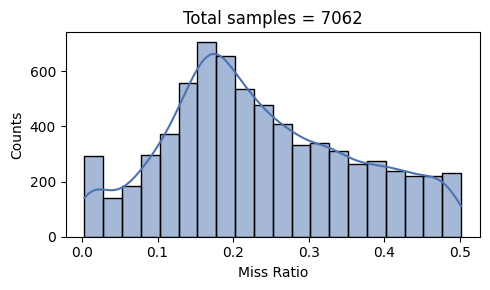

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
mat = gt_enc_aug.gts_toarray()
sample_ratios = (mat == 3).sum(axis=1) / mat.shape[1]

plt.figure(figsize=(5, 3))
sns.histplot(sample_ratios, bins=20, kde=True, color='#4c72b0', edgecolor='k')

plt.title(f'Total samples = {mat.shape[0]}')
plt.xlabel('Miss Ratio')
plt.ylabel('Counts')
plt.tight_layout()
plt.show()

### 1.3 finetuning

In [9]:
gt_enc_urp = GenotypeEncoder(phased=False, gts012=False, save2disk=True, save_dir = Path(work_dir / "finetune"))
gt_enc_urp = gt_enc_urp.encode_ref(
        ref_meta_json = work_dir/"pretrain"/"gt_enc_meta.json",   # 与 Stage1 同构
        default_gt    = 'ref',
        vcf_path      = work_dir/"finetune"/"minor_pops.10pct.vcf.gz",
        evo_mat       = work_dir/"finetune"/"evo_mat_minor_pops.10pct.tsv")

print(f'[URP] {gt_enc_urp.n_samples} samples, {gt_enc_urp.n_variants} variants')

[DATA] 总计 14,867 个位点  
[DATA] EvoMat shape: (29, 29)
[DATA] 结果已写入 /mnt/qmtang/EvoFill_data/20251125_chr22/finetune
[DATA] 位点矩阵 = (29, 14867)，稀疏度 = 45.87%，缺失率 = 0.00%
[DATA] 位点字典 = {'0|1': 1, '1|1': 2, '0|0': 0, '.|.': -1, '0/1': 1, '1/1': 2, '0/0': 0, './.': -1}，字典深度 = 4
[URP] 29 samples, 14867 variants


In [10]:
gt_enc_urp.gts_toarray()

array([[1, 0, 1, ..., 2, 1, 0],
       [1, 0, 2, ..., 1, 0, 0],
       [0, 0, 2, ..., 0, 0, 1],
       ...,
       [1, 0, 2, ..., 0, 0, 0],
       [1, 1, 2, ..., 1, 0, 0],
       [1, 0, 2, ..., 0, 0, 0]], dtype=int8)

### 1.4 validation

In [16]:
gt_enc_imp = GenotypeEncoder(phased=False, gts012=False, save2disk=True, save_dir = Path(work_dir / "impute_in"))
gt_enc_imp = gt_enc_imp.encode_ref(
        ref_meta_json = work_dir/"pretrain"/"gt_enc_meta.json",   # 与 Stage1 同构
        default_gt    = 'ref',
        vcf_path      = work_dir/"impute_in"/"minor_pops.90pct.masked80p.vcf.gz" )

print(f'[INFER] {gt_enc_imp.n_samples} samples, {gt_enc_imp.n_variants} variants')

[DATA] 总计 14,867 个位点  
[DATA] 结果已写入 /mnt/qmtang/EvoFill_data/20251125_chr22/impute_in
[DATA] 位点矩阵 = (269, 14867)，稀疏度 = 89.12%，缺失率 = 80.03%
[DATA] 位点字典 = {'0|1': 1, '1|1': 2, '0|0': 0, '.|.': -1, '0/1': 1, '1/1': 2, '0/0': 0, './.': -1}，字典深度 = 4
[INFER] 269 samples, 14867 variants


## 2. Training with multi-GPUs

### 2.1 [aDNA] Pre-training

In [ ]:
%%bash
cd /mnt/qmtang/EvoFill/
nohup env OMP_NUM_THREADS=8 \
  accelerate launch --config_file ds_zero3.yaml \
  stage1_aDNA-pretrain_ds.py \
  > logs/pre_chr22_251127.log 2>&1 &
%%!

### 2.2 [1KGP] Post-training

In [ ]:
%%bash
cd /mnt/qmtang/EvoFill/
nohup env OMP_NUM_THREADS=8 \
  accelerate launch --config_file ds_zero3.yaml \
  stage2_1kGP-posttrain_ds.py \
  > logs/post_chr22_251127.log 2>&1 &

### 2.3 Ultra-Long-Range LD Module Training

In [ ]:
%%bash

### 2.4 Fine-tuning (Few-shot URP)

In [ ]:
%%bash
cd /mnt/qmtang/EvoFill/
nohup env OMP_NUM_THREADS=8 \
  accelerate launch --config_file ds_zero3.yaml \
  stage4_finetuning_ds.py \
  > logs/finetune_chr22_251125.log 2>&1 &

## 3. Imputation

### 3.1 Load the trained model

Choose a path where including `<work_dir>/model` and have trained model.

In [8]:
work_dir = Path('/mnt/qmtang/EvoFill_data/20251127_chr22')
print(f"Work Dir: {work_dir}")

# ---- 1. 加载模型 ----
device = 'cuda' if torch.cuda.is_available() else 'cpu'

json_path = f"{work_dir}/models/model_meta.json"
meta = json.load(open(json_path))
model = EvoFill(
    n_alleles=int(meta["alleles"]),
    total_sites=int(meta["total_sites"]),
    chunk_size=int(meta["chunk_size"]),
    chunk_overlap=int(meta["overlap"]),
    d_model=int(meta["d_model"]),
    d_state=int(meta["d_state"]),
    headdim=int(meta["headdim"]),
).to(device)

# ckpt = torch.load(f'{work_dir}/models/{meta["model_name"]}_stage1.pth', map_location=device)
ckpt = torch.load(f'{work_dir}/models/{meta["model_name"]}_stage2.pth', map_location=device)
# ckpt = torch.load(f'{work_dir}/models/{meta["model_name"]}_stage3.pth', map_location=device)
# ckpt = torch.load(f'{work_dir}/models/{meta["model_name"]}_CDX_BEB_ASW.pth', map_location=device)
model.load_state_dict(ckpt['model_state'])
model.eval()
print(f'[INF] Model[{meta["model_name"]}] loaded.')

Work Dir: /mnt/qmtang/EvoFill_data/20251127_chr22
[INF] Model[aadr_chr22] loaded.


### 3.2 Inferring

In [9]:
gt_enc_imp = GenotypeEncoder.loadfromdisk(Path(work_dir / "impute_in"))

print(f'[INFER] {gt_enc_imp.n_samples} samples, {gt_enc_imp.n_variants} variants')

# ---- 2. 构建推理 Dataset / Loader ----
imp_dataset = ImputationDataset(
    x_gts_sparse=gt_enc_imp.X_gt,
    seq_depth=gt_enc_imp.seq_depth,
    indices=None                 # 可传入指定样本索引
)
imp_dataset.print_missing_stat()          # 查看原始缺失比例

def collate_fn(batch):
    x_onehot = torch.stack([item[0] for item in batch])
    real_idx_list = [item[1] for item in batch]
    return x_onehot, real_idx_list   # 无 y

imp_loader = torch.utils.data.DataLoader(
    imp_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    collate_fn=collate_fn
)

y_prob = []
y_mask = []
with torch.no_grad():
    for x_onehot, real_idx in tqdm(imp_loader, desc='Imputing'):
        x_onehot = x_onehot.to(device)
        _, prob, _ = model(x_onehot)
        miss_mask = x_onehot[..., -1].bool()
        y_prob.append(prob)
        y_mask.append(miss_mask)
y_prob = torch.cat(y_prob, dim=0).cpu().numpy()
y_mask = torch.cat(y_mask, dim=0).cpu().numpy()
# 4. 保存
out_dir = os.path.join(work_dir, 'impute_out')
os.makedirs(out_dir, exist_ok=True)
np.save(os.path.join(out_dir, 'impute_prob.npy'), y_prob)
np.save(os.path.join(out_dir, 'impute_mask.npy'), y_mask)
print(f'[INF] 概率矩阵已保存 → {out_dir}/impute_prob.npy '
      f'with shape = {y_prob.shape} ')


[INFER] 269 samples, 14867 variants
[ImputationDataset] 269 samples, missing rate = 0.00%


Imputing: 100%|██████████| 5/5 [00:01<00:00,  3.60it/s]


[INF] 概率矩阵已保存 → /mnt/qmtang/EvoFill_data/20251127_chr22/impute_out/impute_prob.npy with shape = (269, 14867, 3) 


### 3.4 Evaluating the imputation results

In [10]:
gt_enc_true = GenotypeEncoder(phased=False, gts012=False, save2disk=False)
gt_enc_true = gt_enc_true.encode_ref(
        ref_meta_json = work_dir/"pretrain"/"gt_enc_meta.json",   # 与 Stage1 同构
        default_gt    = 'ref',
        vcf_path      = work_dir/"impute_out"/"minor_pops.90pct.vcf.gz" )
y_true = gt_enc_true.X_gt.toarray()
maf, bin_cnt = precompute_maf(y_true,  mask_int=gt_enc_true.seq_depth)
y_true_oh = np.eye(gt_enc_true.seq_depth - 1)[y_true]
bins_metrics   = metrics_by_maf(y_prob, y_true_oh, hap_map = gt_enc_true.hap_map, maf_vec = maf, mask=y_mask)
print_maf_stat_df(bin_cnt,{'val': bins_metrics})

[DATA] 总计 14,867 个位点  
[DATA] 位点矩阵 = (269, 14867)，稀疏度 = 45.44%，缺失率 = 0.00%
[DATA] 位点字典 = {'0|1': 1, '1|1': 2, '0|0': 0, '.|.': -1, '0/1': 1, '1/1': 2, '0/0': 0, './.': -1}，字典深度 = 4
     MAF_bin Counts val_Acc val_INFO val_IQS val_MaCH
(0.00, 0.05)   1546   0.972    0.089   0.085    0.193
(0.05, 0.10)   1246   0.935    0.280   0.283    0.463
(0.10, 0.20)   2205   0.890    0.452   0.456    0.685
(0.20, 0.30)   3112   0.824    0.592   0.574    0.850
(0.30, 0.40)   5193   0.787    0.645   0.614    0.906
(0.40, 0.50)   1565   0.770    0.634   0.599    0.894


**= 1kGP ONLY =**

|      MAF_bin | Counts | val_Acc | val_INFO | val_IQS | val_MaCH |
| :----------: | :----: | ------: | -------: | ------: | -------: |
| (0.00, 0.05) |   1546 |   0.972 |    0.060 |   0.068 |    0.166 |
| (0.05, 0.10) |   1246 |   0.931 |    0.198 |   0.216 |    0.367 |
| (0.10, 0.20) |   2205 |   0.875 |    0.332 |   0.353 |    0.545 |
| (0.20, 0.30) |   3112 |   0.798 |    0.487 |   0.495 |    0.754 |
| (0.30, 0.40) |   5193 |   0.755 |    0.550 |   0.552 |    0.853 |
| (0.40, 0.50) |   1565 |   0.739 |    0.548 |   0.545 |    0.845 |


**= aDNA -> 1kGP =** 

     MAF_bin Counts val_Acc val_INFO val_IQS val_MaCH
(0.00, 0.05)   1546   0.972    0.089   0.085    0.193
(0.05, 0.10)   1246   0.935    0.280   0.283    0.463
(0.10, 0.20)   2205   0.890    0.452   0.456    0.685
(0.20, 0.30)   3112   0.824    0.592   0.574    0.850
(0.30, 0.40)   5193   0.787    0.645   0.614    0.906
(0.40, 0.50)   1565   0.770    0.634   0.599    0.894

**= STAGE 4 =** 



### 3.5 Saving to .vcf

In [38]:
from cyvcf2 import VCF, Writer

# 0. 路径
ref_vcf = "/mnt/qmtang/EvoFill_data/20251107_ver4/minor_pops.masked30p.vcf.gz"
out_vcf = os.path.join(out_dir, 'imputed.vcf.gz')

n_site = gt_enc.n_variants
n_samp = gt_enc.n_samples
n_alleles = gt_enc.seq_depth - 1
assert y_prob.shape == (n_samp, n_site, n_alleles)

# 2. 反向映射  idx -> '0|0' / '0|1' / ...
rev_hap_map = {v: k for k, v in gt_enc.hap_map.items()}

samp2idx = {sid: i for i, sid in enumerate(gt_enc.sample_ids)}

# 4. 打开参考 VCF
invcf = VCF(ref_vcf)
tmpl  = invcf
tmpl.set_samples(gt_enc.sample_ids)   # 替换样本列

out = Writer(out_vcf, tmpl, mode='wz')

for rec_idx, rec in enumerate(invcf):
    # 当前位点全部样本的 GT
    gt_int_pairs = []
    for samp_idx, sample_id in enumerate(gt_enc.sample_ids):
        old_gt = rec.genotypes[samp_idx]          # [allele1, allele2, phased]
        if old_gt[0] == -1 or old_gt[1] == -1:    # 缺失
            prob_vec = y_prob[samp_idx, rec_idx, :].ravel()
            best_idx = int(prob_vec.argmax())
            gt_str   = rev_hap_map[best_idx]
            alleles  = list(map(int, gt_str.split('|')))
            phased   = old_gt[2] if old_gt[2] != -1 else 1
            gt_int_pairs.append([alleles[0], alleles[1], phased])
        else:                                       # 非缺失，保持原样
            gt_int_pairs.append(old_gt)

    # 转成 int8 二维数组  (n_sample, 3)  last dim = [a1,a2,phased]
    gt_array = np.array(gt_int_pairs, dtype=np.int8)
    rec.set_format('GT', gt_array)
    out.write_record(rec)

invcf.close()
out.close()

# 5. tabix
os.system(f'tabix -fp vcf {out_vcf}')
print(f'[INF] 缺失位点填充完成 → {out_vcf}')

[INF] 缺失位点填充完成 → /mnt/qmtang/EvoFill_data/20251107_ver4/impute_out/imputed.vcf.gz
